In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import arviz as az
import stan

from sklearn.linear_model import BayesianRidge
from sklearn.utils import shuffle

import nest_asyncio
nest_asyncio.apply()

# Bayesian Multiple Regression: an Insurance Model

> Please note: this notebook combines both Problem 05 and Problem 06 for this assignment. We did our best to partition this notebook so that it is easy to grade, and we label which part goes to which problem anywhere we can. When grading, please consider these problems together as one problem. 

In this notebook, we implement a multiple Bayesian Linear Regression model. This model is used to fit the [Insurance Cost dataset](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv), where we predict the insurance charges based upon a patient's BMI, age, and children count.

This model is implemented in two ways: both in `Stan` and with `scikit-learn`'s Bayesian Ridge regression implementation.

## Part 0: Data Preprocessing

> This part goes to Problem 05.

In [4]:
# Reading in the data
all_data = pd.read_csv('./data/insurance.csv', delimiter=";")

In [5]:
# Inspecting the content of the data
all_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
# Inspecting how much data there is
all_data.shape

(1338, 7)

We only need a subset of this data: `age`, `bmi`, and `children` as predictors, and `charges` as our target for estimates. Judging by how much data this dataset has, we can intuitively split it into a training set of size 1000, and a testing set of size 338. This roughly corresponds to a `4:1` split.

In [7]:
data = all_data[['age','bmi', 'children', 'charges']]
data.shape

(1338, 4)

Before we split the data, several pre-processing steps need to happen. First, we observe the standard deviation for each item in our dataset.

In [8]:
charges_std = data['charges'].std()
std = np.std(data, axis=0)
std

age            14.044709
bmi             6.095908
children        1.205042
charges     12105.484976
dtype: float64

Then, we develop two helper functions to standardize our data.

In [9]:
def z_standardize(input_data):
    """ 
    Helper function to standardize data.

    Parameters
    ----------
    Input_data      : np.array
        Input data to be standardized
    
    Returns
    -------
    output_data     : np.array
        Standardized data
    """

    output_data = (input_data - np.mean(input_data, axis=0)) / np.std(input_data, axis=0)

    return output_data

def destandardize(data_z, input_mean, input_std):
    """ 
    Helper function to destandardize data.
    """

    return data_z * input_std + input_mean 

We standardize all data.

In [10]:
# Perform z_standardization for all data
data_z = z_standardize(data)
data_z

,age,bmi,children,charges
0,-1.438764,-0.453320,-0.908614,0.298584
1,-1.509965,0.509621,-0.078767,-0.953689
2,-0.797954,0.383307,1.580926,-0.728675
3,-0.441948,-1.305531,-0.908614,0.719843
4,-0.513149,-0.292556,-0.908614,-0.776802
...,...,...,...,...
1333,0.768473,0.050297,1.580926,-0.220551
1334,-1.509965,0.206139,-0.908614,-0.914002
1335,-1.509965,1.014878,-0.908614,-0.961596
1336,-1.296362,-0.797813,-0.908614,-0.930362


This standardized data is used for the train-test split.

In [11]:
# Perform a train-test split with a simple cutoff index 1000.

# First, shuffle the dataset to ensure consistency between training and testing set
data_z = shuffle(data_z)

In [21]:
# Then do the split.
train_data = data_z[0:1000].to_numpy()
test_data  = data_z[1000:].to_numpy()

## Part 1: Generative Model with Stan

### Model definition

> The model programmed below is used for both Problem 05 and 06.

Next, we will build a simple Bayesian regression model of the form:
$$
\begin{align}
    \nonumber \sigma &\sim \text{Inv-Gamma}(\tau_0, \tau_1)\\
    \nonumber \alpha &\sim \text{Normal}(0, \sigma_\alpha)\\
    \nonumber \beta &\sim \text{Multivariate-Normal}(0, \sigma_\beta \mathbb{I})\\
\nonumber y_n &\sim \mathrm{Normal}(\alpha + \beta\,x_n^T, \sigma) \quad \text{for} \,\, n = 1,\dots,N
\end{align}
$$

For the model, we set the hyperparameters $\tau_0 = \tau_1 = 1, \sigma_\alpha = 10, \sigma_\beta = (1, 1, 1)$.

In [66]:
insurance_code = """ 
data {
    int<lower=1> N; // Number of training data
    int<lower=1> M; // Number of testing data
    int<lower=1> K; // Number of predictors
    matrix[N, K] x; // Predictors in training set
    matrix[M, K] z; // Predictors in testing set
    vector[N] y;    // Vector of estimates
}

parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma;
}

model {
    // Priors
    alpha ~ normal(0, 10);
    beta ~ multi_normal(rep_vector(0, K), identity_matrix(K));
    sigma ~ inv_gamma(1, 1);

    // Likelihood
    y ~ normal(alpha + x * beta, sigma);
}

generated quantities {   
    vector[M] preds;
    for (m in 1:M) {
        preds[m] = normal_rng(alpha + z[m] * beta, sigma);
    } 
}
"""

We further split the data into predictors and estimator, and feed it into the structured data used for the `Stan` model.

In [64]:
train_predictors = train_data[:,0:3]
test_predictors = test_data[:,0:3]

insurance_data = {
    "N": train_data.shape[0],
    "M": test_data.shape[0],
    "K": train_predictors.shape[1],
    "x": train_predictors,
    'z': test_predictors,
    "y": train_data[:,-1]
}

test_predictors.shape

(338, 3)

Now we build the model and sample the posterior.

In [67]:
insurance_posterior = stan.build(program_code=insurance_code, data=insurance_data, random_seed=1069)

Building...


Building: 49.1s, done.

In [69]:
fit = insurance_posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Sampling:   0%
Sampling:   4% (500/14000)
Sampling:  29% (4000/14000)
Sampling:  54% (7500/14000)
Sampling:  79% (11000/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 0.000817 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000885 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.85 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000376 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.76 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000266 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.66 seconds.
  Adjust your expectations accordingly!


### Efficiency and convergence diagnostics

> This part belongs to Problem 05.

First, we check the efficiency and convergence of the model. As indicated in the summary and the trace plot, the model is efficient and it converges!

In [71]:
var_names = ['alpha', 'beta', 'sigma']

az.summary(fit, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.012,0.029,-0.066,0.043,0.0,0.0,11719.0,7913.0,1.0
beta[0],0.293,0.030,0.234,0.348,0.0,0.0,11571.0,7688.0,1.0
beta[1],0.162,0.029,0.108,0.218,0.0,0.0,12155.0,8477.0,1.0
beta[2],0.056,0.030,0.002,0.112,0.0,0.0,11183.0,7613.0,1.0
sigma,0.929,0.021,0.889,0.968,0.0,0.0,12349.0,8193.0,1.0


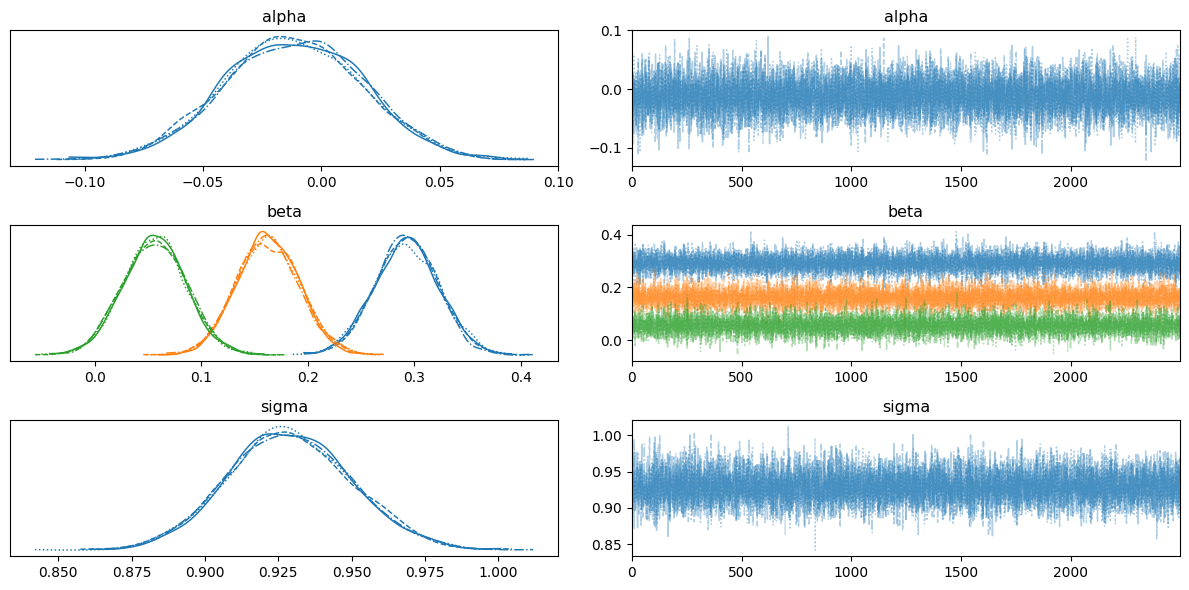

In [73]:
ax = az.plot_trace(fit, var_names=var_names)
plt.tight_layout()

### Predictor performance

> This part goes to Problem 05.

Based upon the means of estimated parameters, it is concluded that `age`, which corresponds to $\beta_0 = 0.293$, is the best predictor. This is followed by `bmi`, with $\beta_1 = 0.162$, and the number of `children`, with $\beta_1 = 0.056$.

### Predictive Distribution

> This part goes to Problem 06.

Next, we observe the predictive distribution through the generated quantities from the `stan` model. We extract the samples, computed the sample means and global mean, and plot the sample means as histogram.

In [87]:
# Extract generated predictive samples
pred_samples = fit.to_frame().iloc[:,12:]

# Compute sample means and global means
sample_means = pred_samples.mean()
global_mean = sample_means.mean()

<Axes: ylabel='Count'>

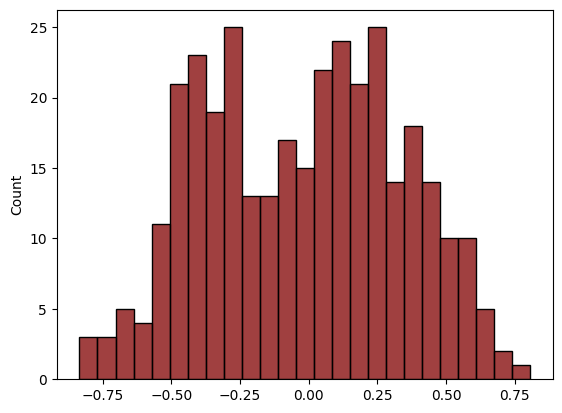

In [103]:
# Plot the predictive distribution
sns.histplot(sample_means, bins=25, color="maroon")

Next, we compute the root-mean-square error (RMSE). By construction, the RMSE is essentially the L2-norm of the element-wise difference between data and prediction. Thus, we implement a sweet little function that takes advantage of this fact.

In [92]:
## Helper funcion to compute root-mean-square error (RMSE)
def rmse(data, preds):
    M = data.shape[0]
    assert(preds.shape[0] == M)

    ## L2 norm is also called *Fro*benius norm
    return np.linalg.norm(data - preds, 'fro') * np.sqrt(1/M)

In [93]:
e = rmse(test_data[:,-1], pred_samples.mean())
e

0.9730123573270819

To eliminate doubt, we also implement the equation in raw form.

In [100]:
## Validate that the result is correct by performing a raw calculation through direct implementation, in case of doubt.
rmse_manual = np.sqrt(np.sum((pred_samples.mean() - test_data[:,-1])**2) / test_data[:,-1].shape[0])
rmse_manual

0.9730123573270819

### Discussion

Bearing in mind that the data is z-standardized, an RMSE of 0.973 indicates that the predictive means are being considered as about one standard deviation away from the real data as ground truth, on average. As a result, the prediction is not very accurate. 

Why is that? Part of the reasons has to do with model complexity. Only three predictors are at play. Increasing model complexity would result in more accurate prediction.

By computing predictive means, the aleatoric uncertainty is lost, due to the fact that we average out the individual predictive samples, where the uncertainty lies. To propagate this uncertainty, we can perform multiple runs of train-test split, and use different test data to compute a set of RMSE values. This set of RMSE would then have a distribution that encodes the predictive uncertainty.

## Part 2: Generative Model with Bayesian Ridge Regression

Coming soon.